<a href="https://colab.research.google.com/github/DanBaissa/symbolic_regression_polisci/blob/main/Symbolic_Regression_Political_Science_Edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression in Political Science: Classic Models

---

## Overview

This educational notebook demonstrates how **symbolic regression**—a machine learning technique that automatically discovers mathematical equations—can help political scientists and social scientists uncover the underlying functional relationships in data. Instead of pre-selecting a model form (like linear or quadratic), symbolic regression explores a huge space of possible equations and finds the one(s) that best fit the observed data. This makes it especially useful for:

- Detecting non-linearities, thresholds, and cycles that traditional regressions may miss.
- Revealing interaction effects and complex dynamics.
- Providing **interpretable formulas** instead of black-box predictions.

The notebook combines classic social science and political economy data-generating processes (linear, quadratic, interaction, cyclical) and demonstrates how symbolic regression can discover these relationships using two tools:

- Python’s `gplearn` (genetic programming)
- Julia’s `PySR` (highly efficient, often simpler equations)

For each dataset, you’ll see:

- The context and political science analogy
- The discovered formula (compared to the “ground truth”)
- The test-set fit (R²)
- Example paper-style writeups for interpreting your findings

## 1. Installation and Imports

In [1]:
!pip install gplearn pysr julia ace_tools
import julia
julia.install()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from pysr import PySRRegressor
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.2 MB/s eta 0:00:00



Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
             Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             [compat]
             SymbolicRegression = "~1.11"
             Serialization = "^1"
             PythonCall = "=0.9.25"
             OpenSSL_jll = "~3.0"
[juliapkg] Installing packages:
             import Pkg
    

In [2]:
!git clone https://github.com/DanBaissa/symbolic_regression_polisci.git
%cd symbolic_regression_polisci

Cloning into 'symbolic_regression_polisci'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 697.69 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/symbolic_regression_polisci


## 2. Data Generation: Classic Relationships

In [3]:
rng = np.random.default_rng(42)
X = np.linspace(-3, 3, 200).reshape(-1, 1)

# Classic models
y_linear = 2.5 * X.ravel() + 3 + rng.normal(0, 0.1, X.shape[0])
y_quadratic = -1.2 * (X.ravel() ** 2) + 2 * X.ravel() + 1 + rng.normal(0, 0.1, X.shape[0])
X2 = rng.uniform(-3, 3, X.shape[0])
y_interaction = 1.5 * X.ravel() * X2 + 0.5 * X2 + rng.normal(0, 0.1, X.shape[0])
y_sinusoidal = 1.8 * np.sin(1.5 * X.ravel()) + 0.2 * X.ravel() + rng.normal(0, 0.1, X.shape[0])

# Causal inference models
# Difference-in-Differences
treatment = (X.ravel() > 0).astype(int)
post = (rng.uniform(-1, 1, X.shape[0]) > 0).astype(int)
interaction = treatment * post
y_did = 2 * treatment + 1.5 * post + 3 * interaction + rng.normal(0, 0.5, X.shape[0])
X_did = np.column_stack([treatment, post, interaction])

# Sharp RD
X_rd = X.ravel()
y_rd = 2 + 3 * (X_rd >= 0).astype(int) + 0.5 * X_rd + rng.normal(0, 0.3, X.shape[0])
X_rd = X_rd.reshape(-1, 1)

# Fuzzy RD
treatment_prob = 1 / (1 + np.exp(-10 * X.ravel()))
fuzzy_treatment = rng.binomial(1, treatment_prob)
y_fuzzy_rd = 1.5 * fuzzy_treatment + 0.5 * X.ravel() + rng.normal(0, 0.3, X.shape[0])
X_fuzzy = X

# Instrumental Variables
Z = rng.integers(0, 2, size=X.shape[0])
X_iv = 0.7 * Z + rng.normal(0, 0.1, X.shape[0])
y_iv = 2.0 * X_iv + rng.normal(0, 0.3, X.shape[0])
X_iv_stack = np.column_stack([X_iv, Z])

# Bundle everything
datasets = [
    ("Linear", X, y_linear, None),
    ("Quadratic", X, y_quadratic, None),
    ("Interaction", np.column_stack([X.ravel(), X2]), y_interaction, X2),
    ("Sinusoidal", X, y_sinusoidal, None),
    ("Diff-in-Diff", X_did, y_did, None),
    ("Sharp RD", X_rd, y_rd, None),
    ("Fuzzy RD", X_fuzzy, y_fuzzy_rd, None),
    ("Instrumental Vars", X_iv_stack, y_iv, None)
]


## 3. Symbolic Regression with Python (`gplearn`)


=== Linear (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): mul(add(0.991, add(X0, 0.194)), div(0.991, 0.394))
Test set R^2: 1.000


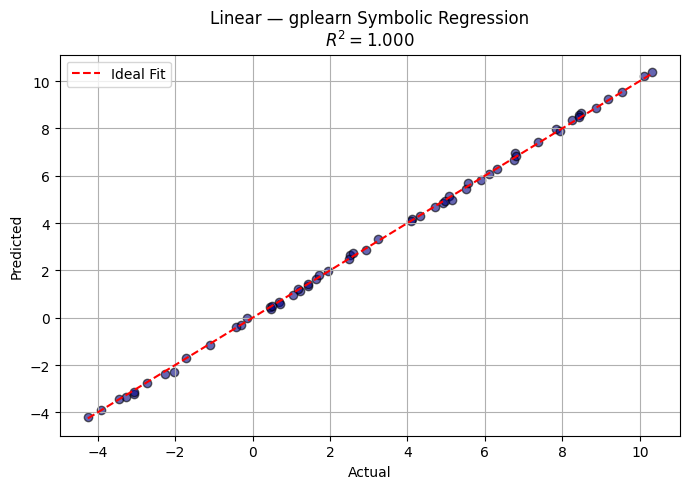


=== Quadratic (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): sub(add(sub(0.817, X0), add(X0, 0.138)), add(add(mul(X0, X0), mul(-0.693, X0)), add(mul(-0.963, X0), mul(-0.223, add(sub(X0, mul(add(0.388, X0), X0)), sub(X0, -0.428))))))
Test set R^2: 0.999


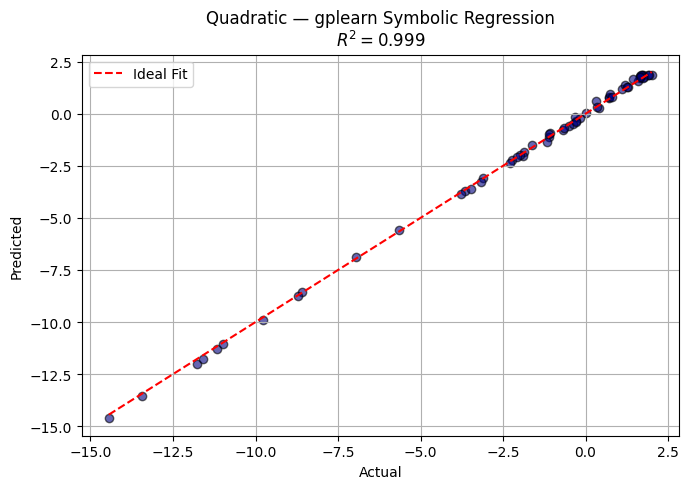


=== Interaction (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): mul(add(0.633, sub(add(X0, X0), mul(0.662, mul(0.662, X0)))), X1)
Test set R^2: 0.995


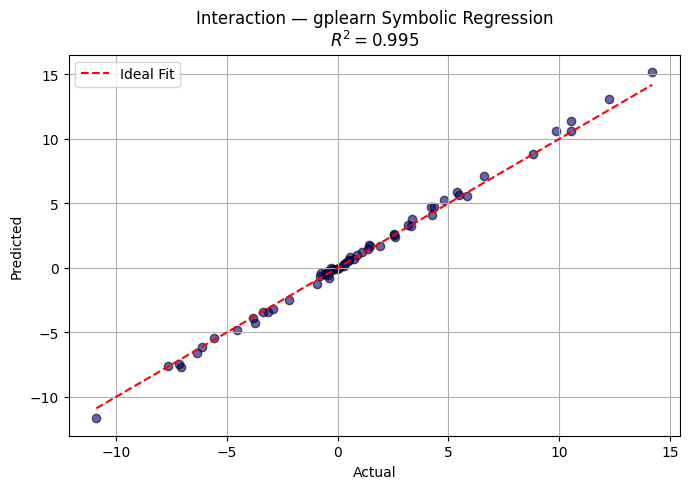


=== Sinusoidal (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): div(div(add(X0, X0), X0), sub(X0, div(-0.487, X0)))
Test set R^2: 0.691


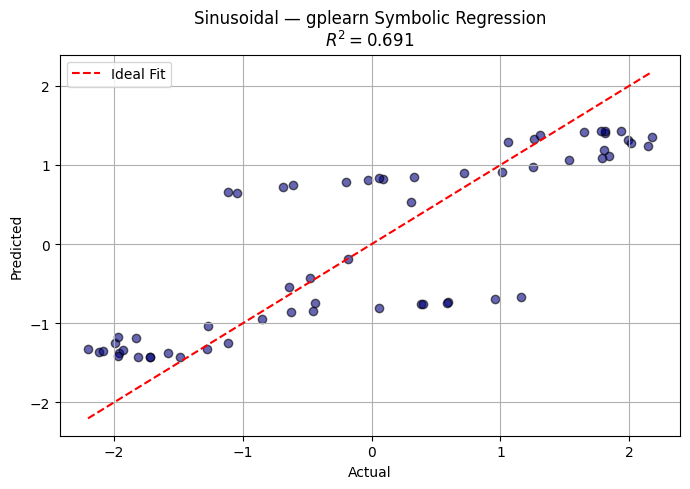


=== Diff-in-Diff (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): mul(add(X1, X0), add(add(X1, X0), add(0.201, X0)))
Test set R^2: 0.953


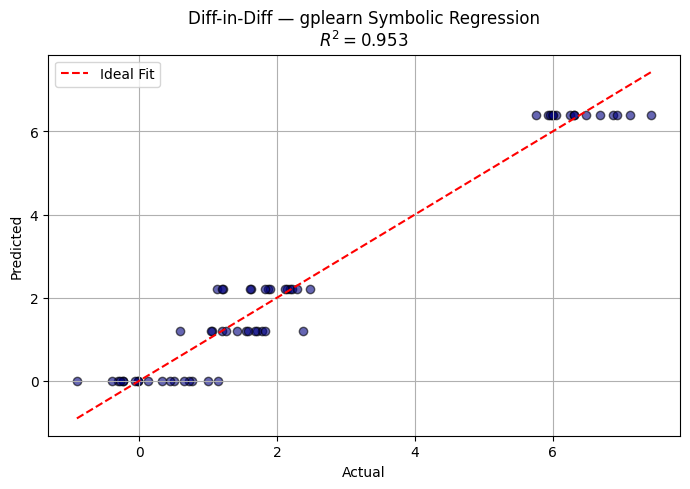


=== Sharp RD (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): add(div(0.980, 0.362), add(0.832, div(X0, 0.832)))
Test set R^2: 0.845


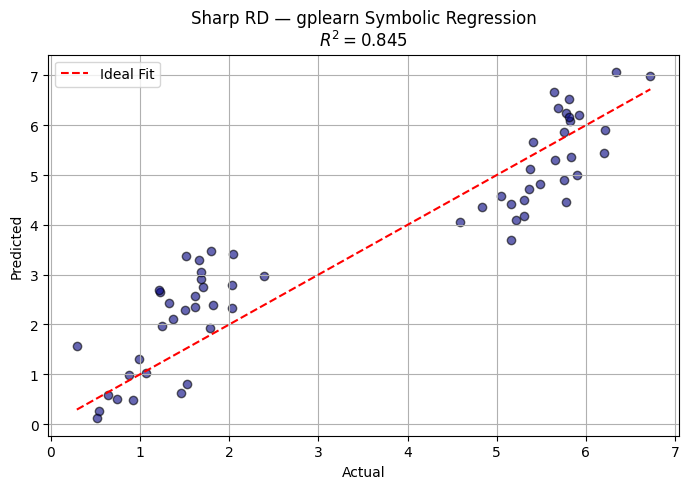


=== Fuzzy RD (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): add(0.727, mul(0.859, X0))
Test set R^2: 0.898


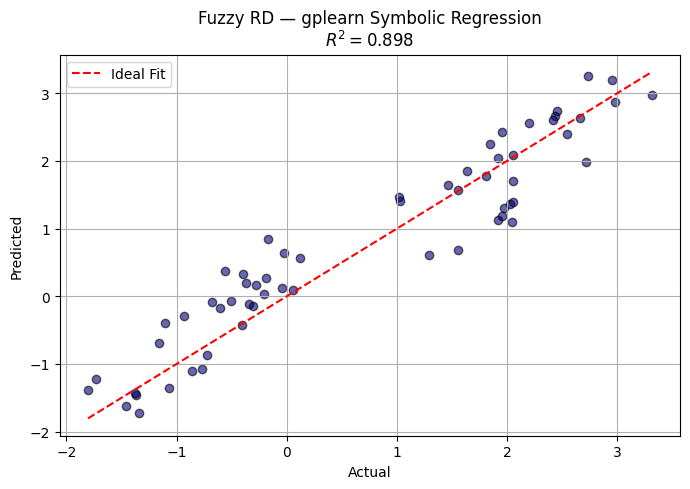


=== Instrumental Vars (Python/gplearn) ===


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Discovered equation (Python): add(X0, X0)
Test set R^2: 0.847


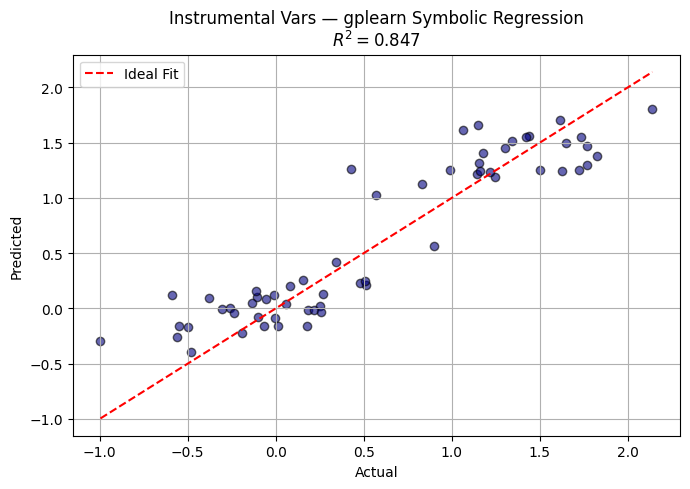

In [5]:
import matplotlib.pyplot as plt

gplearn_results = []

for name, X_data, y_data, _ in datasets:
    print(f"\n=== {name} (Python/gplearn) ===")
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
    py_est = SymbolicRegressor(
        population_size=1000,
        generations=20,
        stopping_criteria=0.01,
        p_crossover=0.7,
        p_subtree_mutation=0.1,
        p_hoist_mutation=0.05,
        p_point_mutation=0.1,
        max_samples=0.9,
        verbose=0,
        parsimony_coefficient=0.01,
        random_state=0
    )
    py_est.fit(X_train, y_train)
    y_pred_py = py_est.predict(X_test)
    py_r2 = r2_score(y_test, y_pred_py)
    py_eq = str(py_est._program)
    print(f"Discovered equation (Python): {py_eq}")
    print(f"Test set R^2: {py_r2:.3f}")
    gplearn_results.append({'name': name, 'eq': py_eq, 'r2': py_r2})

    # === PLOTTING ===
    plt.figure(figsize=(7,5))
    plt.scatter(y_test, y_pred_py, alpha=0.6, color='navy', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.title(f"{name} — gplearn Symbolic Regression\n$R^2 = {py_r2:.3f}$")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


## 4. Symbolic Regression with Julia (`PySR`): All Datasets






In [6]:
pysr_results = []

for name, X_data, y_data, _ in datasets:
    print(f"\n=== {name} (Julia/PySR) ===")
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

    model = PySRRegressor(
        model_selection="best",
        verbosity=0,
        parsimony=0.01,
    )

    model.fit(X_train, y_train)
    y_pred_jl = model.predict(X_test)
    jl_r2 = r2_score(y_test, y_pred_jl)

    best_eq = model.get_best().equation  # ✅ This gives a clean string like "x0*2.5 + 3"

    print("Discovered equation (Julia):", best_eq)
    print("Test set R^2:", jl_r2)

    pysr_results.append({'name': name, 'eq': best_eq, 'r2': jl_r2})



=== Linear (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): (x0 - -1.2002021) * 2.501902
Test set R^2: 0.9995828227659432

=== Quadratic (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): ((x0 / -0.83078617) * (x0 + -1.6653484)) + 1.019319
Test set R^2: 0.9994442507144493

=== Interaction (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): ((x0 * 1.5023068) + 0.50024205) * x1
Test set R^2: 0.9995869913091724

=== Sinusoidal (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): ((((((x0 * 0.07195739) * x0) * x0) - (x0 / (((x0 * x0) - -5.0624356) / -16.68075))) - x0) - x0) / 0.40762696
Test set R^2: 0.9927995355072605

=== Diff-in-Diff (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): ((x0 + x2) + x1) * 2.080292
Test set R^2: 0.943926164196199

=== Sharp RD (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): ((0.0056805685 / x0) + 0.86450475) * ((x0 + 4.012908) - (-1.5526999 / (x0 + (0.21101256 / x0))))
Test set R^2: 0.967027797665497

=== Fuzzy RD (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): x0 / ((-1.2554176 / (x0 + (0.6228852 / (x0 - -0.5298713)))) + 1.403664)
Test set R^2: 0.9117037866044607

=== Instrumental Vars (Julia/PySR) ===


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Discovered equation (Julia): x0 * 2.1019256
Test set R^2: 0.8401161818382736


## 5. Comparing Results: Table of Equations and Performance



In [7]:
summary = []
for g, j in zip(gplearn_results, pysr_results):
    summary.append({
        'Relationship': g['name'],
        'Python Equation': g['eq'],
        'Python R²': f"{g['r2']:.3f}",
        'Julia Equation': j['eq'],
        'Julia R²': f"{j['r2']:.3f}",
    })
df_summary = pd.DataFrame(summary)

from IPython.display import display
display(df_summary.style.set_properties(**{'text-align': 'left'}))


,Relationship,Python Equation,Python R²,Julia Equation,Julia R²
0,Linear,"mul(add(0.991, add(X0, 0.194)), div(0.991, 0.394))",1.000,(x0 - -1.2002021) * 2.501902,1.000
1,Quadratic,"sub(add(sub(0.817, X0), add(X0, 0.138)), add(add(mul(X0, X0), mul(-0.693, X0)), add(mul(-0.963, X0), mul(-0.223, add(sub(X0, mul(add(0.388, X0), X0)), sub(X0, -0.428))))))",0.999,((x0 / -0.83078617) * (x0 + -1.6653484)) + 1.019319,0.999
2,Interaction,"mul(add(0.633, sub(add(X0, X0), mul(0.662, mul(0.662, X0)))), X1)",0.995,((x0 * 1.5023068) + 0.50024205) * x1,1.000
3,Sinusoidal,"div(div(add(X0, X0), X0), sub(X0, div(-0.487, X0)))",0.691,((((((x0 * 0.07195739) * x0) * x0) - (x0 / (((x0 * x0) - -5.0624356) / -16.68075))) - x0) - x0) / 0.40762696,0.993
4,Diff-in-Diff,"mul(add(X1, X0), add(add(X1, X0), add(0.201, X0)))",0.953,((x0 + x2) + x1) * 2.080292,0.944
5,Sharp RD,"add(div(0.980, 0.362), add(0.832, div(X0, 0.832)))",0.845,((0.0056805685 / x0) + 0.86450475) * ((x0 + 4.012908) - (-1.5526999 / (x0 + (0.21101256 / x0)))),0.967
6,Fuzzy RD,"add(0.727, mul(0.859, X0))",0.898,x0 / ((-1.2554176 / (x0 + (0.6228852 / (x0 - -0.5298713)))) + 1.403664),0.912
7,Instrumental Vars,"add(X0, X0)",0.847,x0 * 2.1019256,0.840


## 6. Symbolic Regression: Democracy and Redistribution (Applied Example)

### A. Merge the Data

In [8]:
# Load both datasets
df_wb = pd.read_csv("Data/world_bank.csv")
df_polity = pd.read_csv("Data/polity.csv")

# Melt polity into long format
df_polity_long = pd.melt(df_polity, id_vars=['year'], var_name='country_code', value_name='polity')

# Now merge
df = pd.merge(df_wb, df_polity_long, on=['country_code', 'year'], how='inner')

# Drop missing values for modeling
df = df.dropna(subset=['inf_mort', 'polity', 'gdp_per_capita', 'year', 'pop_density'])


### B. Symbolic Regression: Does Democracy Predict Infant Mortality?

#### SymbolicRegressor

#### Julia's Version

In [9]:
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import display, Latex

feature_names = ['polity', 'gdp_per_capita', 'year', 'pop_density']
X = df[feature_names].values
y = df["inf_mort"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = PySRRegressor(
    niterations=40,
    model_selection="best",
    verbosity=0,
    parsimony=0.001
)

model.fit(X_train, y_train, variable_names=feature_names)

best_eq = model.get_best().equation
r2 = model.score(X_test, y_test)
latex_eq = model.latex(precision=3)




/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [10]:
print(f"Best Equation: {best_eq}")
print(f"Test R²: {r2:.3f}")
print("LaTeX equation:")
print(latex_eq)

# Display nicely in notebook
display(Latex(f"\\[ {latex_eq} \\]"))

Best Equation: (2007.4901 - year) + (-162958.89 / (-665.4816 - gdp_per_capita))
Test R²: 0.674
LaTeX equation:
- year + 2.01 \cdot 10^{3} - \frac{1.63 \cdot 10^{5}}{- gdp_{per capita} - 666.}


<IPython.core.display.Latex object>

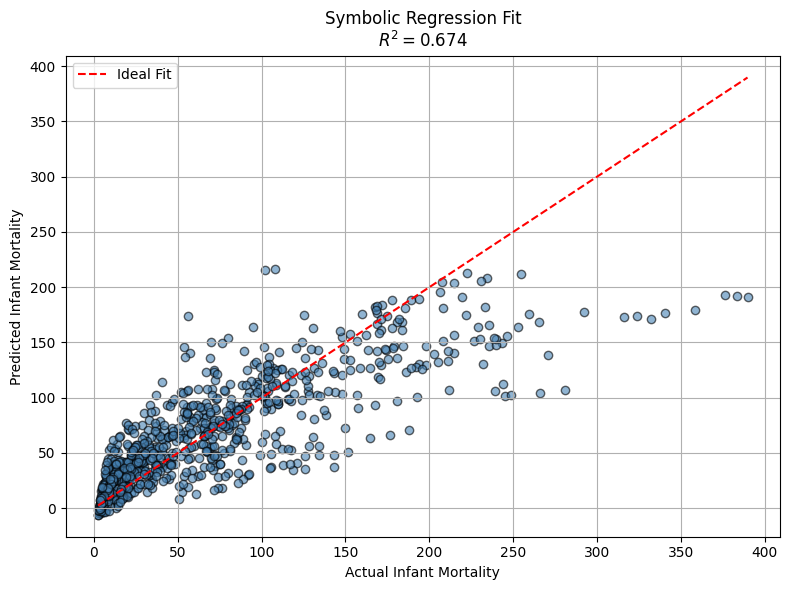

In [11]:
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='steelblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Infant Mortality")
plt.ylabel("Predicted Infant Mortality")
plt.title(f"Symbolic Regression Fit\n$R^2 = {r2:.3f}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
